In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings


def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

working dir is '/Users/hemker konstantin/Documents/repos/Facet/facet'
added `/Users/hemker konstantin/Documents/repos/Facet/pytools/src` to python paths
added `/Users/hemker konstantin/Documents/repos/Facet/facet/src` to python paths
added `/Users/hemker konstantin/Documents/repos/Facet/sklearndf/src` to python paths


In [43]:
def data_sim(n=100,
             intercept=-5,
             linear_vars=10,
             noise_vars=0,
             corr_vars=0,
             corr_type="AR1",
             corr_value=0,
             mislabel=0,
             surg_err=0.05,
             bin_var_p=0,
             bin_coef=0,
             outcome="classification",
             regression_err=None,
             ):
    """
    This function is for the most part a direct translation of the twoClassSim function from the R package caret.
    Full credit for the approach used for simulating binary classification data foes to the Authors and contributors
    of caret.

    There are some modifications from the R implementation:
    1. The ordinal outcome option has not been translated
    2. The addition of another linear feature that is a copy of another used in the linear predictor with a small amount
    of noise has been added to allow for the study of variable surrogacy
    3. Option for a binary predictor and surrogate has also been added
    4. Toggle option for regression versus classification has also been added

    Source:
        Caret: Kuhn, M. (2008). Caret package. Journal of Statistical Software, 28(5)
        https://rdrr.io/cran/caret/man/twoClassSim.html

    :param n: number of observations
    :param intercept: value for the intercept which can be modified to generate class imbalance
    :param linear_vars: number of linear features
    :param noise_vars: number of noise features (i.e., do not contribute to the linear predictor)
    :param corr_vars: number of correlated noise features
    :param corr_type: type of correlation (exchangeable or auto-regressive) for correlated noise features
    :param corr_value: correlation for correlated noise features
    :param mislabel: proportion of mis-labelling of target if required
    :param surg_err: degree of noise added to first linear predictor
    :param bin_var_p: prevalence for a binary feature to include in linear predictor
    :param bin_coef: coefficient for the impact of binary feature on linear predictor
    :param outcome: can be either classification for a binary outcome or regression for a continuous outcome
    :param regression_err: the error to be used in simulating a regression outcome
    :return: data frame containing the simulated features and target for classification

    """

    # set seed
    np.random.seed(seed=4763546)

    # add two correlated normal features
    sigma = np.array([[2, 1.3], [1.3, 2]])
    mu = [0, 0]
    tmp_data = pd.DataFrame(np.random.multivariate_normal(mu, sigma, size=n), columns=["TwoFactor1", "TwoFactor2"])

    # add linear features
    if linear_vars > 0:
        lin_cols = ['Linear' + str(x) for x in range(1, linear_vars + 1)]
        tmp_data = pd.concat([tmp_data, pd.DataFrame(np.random.normal(size=(n, linear_vars)), columns=lin_cols)],
                             axis=1)

    # add features for non-linear terms
    tmp_data['Nonlinear1'] = pd.Series(np.random.uniform(low=-1.0, high=1.0, size=n))
    tmp_data = pd.concat([tmp_data, pd.DataFrame(np.random.uniform(size=(n, 2)), columns=['Nonlinear2', 'Nonlinear3'])],
                         axis=1)

    # add noise variables as needed
    if noise_vars > 0:
        noise_cols = ['Noise' + str(x) for x in range(1, noise_vars + 1)]
        tmp_data = pd.concat([tmp_data, pd.DataFrame(np.random.normal(size=(n, noise_vars)), columns=noise_cols)],
                             axis=1)

    # add correlated noise features
    if corr_vars > 0:
        if corr_type == "exch":
            vc = corr_value * np.ones((corr_vars, corr_vars))
            np.fill_diagonal(vc, 1)

        elif corr_type == "AR1":
            vc_values = corr_value ** np.arange(corr_vars)
            vc = toeplitz(vc_values)

        corr_cols = ['Corr' + str(x) for x in range(1, corr_vars + 1)]
        tmp_data = pd.concat([tmp_data,
                              pd.DataFrame(np.random.multivariate_normal(np.zeros(corr_vars), vc, size=n),
                                           columns=corr_cols)],
                             axis=1)

    # add a surrogate linear feature
    if linear_vars > 0:
        tmp_data['Linear1_prime'] = tmp_data['Linear1'] + np.random.normal(0, surg_err, size=n)

    # add a binary feature
    if bin_var_p > 0:
        tmp_data['Binary1'] = np.where(np.random.uniform(size=n) <= bin_var_p, 0, 1)

    # generate contributions to linear predictor 4, 4, 2
    lp = intercept + 4 * tmp_data.TwoFactor1 + 4 * tmp_data.TwoFactor2 + 2 * tmp_data.TwoFactor1 * tmp_data.TwoFactor2 \
         + tmp_data.Nonlinear1 ** 3 + 2 * np.exp(-6 * (tmp_data.Nonlinear1 - 0.3) ** 2) + \
         2 * np.sin(np.pi * tmp_data.Nonlinear2 * tmp_data.Nonlinear3)
        

    if linear_vars > 0:
        lin_coeff = np.linspace(10, 1, num=linear_vars) / 4
        neg_idx = [_ for _ in range(1, linear_vars, 2)]
        lin_coeff[neg_idx] = lin_coeff[neg_idx] * -1
        lp = lp + tmp_data[lin_cols].dot(lin_coeff)

    if bin_var_p > 0:
        lp = lp + bin_coef * tmp_data['Binary1']
        tmp_data['Binary1_prime'] = 1 - tmp_data['Binary1']

    if outcome == 'classification':

        # convert to a probability
        prob = 1 / (1 + np.exp(-lp))

        # add mislabelling if desired - TO DO: need to fix
        if (mislabel > 0) and (mislabel < 1):
            shuffle_rows = np.random.choice(n, np.floor(n * mislabel), replace=False)
            prob[shuffle_rows] = 1 - prob[shuffle_rows]

        # generate target
        tmp_data['target'] = np.where(prob <= np.random.uniform(size=n), 0, 1)

    elif outcome == 'regression':

        # continuous outcome based on linear predictor
        tmp_data['target'] = np.random.normal(lp, regression_err, size=n)

    return tmp_data

# Imports

Conventional imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import *
from sklearn.preprocessing import MinMaxScaler

Gamma Facet imports

In [2]:
from facet import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

Sklearndf imports

Instead of using the "regular" scikit-learn package, we are using the `sklearndf` (see on [GitHub](https://github.com/orgs/BCG-Gamma/sklearndf/)) wrapper which keeps metadata such as column names when passing the data through the scikit-learn learners.  

In [44]:
# sklearndf
from sklearndf.pipeline import PipelineDF, RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF
from sklearndf.regression.extra import LGBMRegressorDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import SimpleImputerDF


In [45]:
from pytools.viz.dendrogram import DendrogramDrawer, DendrogramReportStyle
from pytools.viz.distribution import ECDFDrawer
from pytools.viz.matrix import MatrixDrawer

In [46]:
def scale_var(df: pd.DataFrame, 
              feature_name: str, 
              min_: Union[int, float] =0, 
              max_: Union[int, float]=1) -> np.array: 
    """
    Takes in a data frame and applies a min-max scaler to given bounds for a single column
    """
    
    scaler = MinMaxScaler(feature_range=(min_, max_))
    scaled_arr = scaler.fit_transform(df[[feature_name]]).reshape(1, -1)[0]
    return scaled_arr


In [47]:
df = data_sim(n=500,
             intercept=0,
             linear_vars=3,
             noise_vars=1,
             corr_vars=0,
             corr_type="AR1",
             corr_value=0.4,
             mislabel=0,
             surg_err=0.05,
             bin_var_p=0,
             bin_coef=0,
             outcome="regression",
             regression_err=0.2,
             )

In [1]:
df.rename({ 
    "TwoFactor1": "Weight on bit (kg)", # higher weight --> higher weight will increase risks of danger 
    "TwoFactor2": "Drill rate (m/s)", # higher drill rate --> higher drill rate will provide less time for drilling engineers to observe real time data and adjust drilling parameter set up -> leading to a higher risk of incident (but more economic to drill faster)
    "Linear1": "Vertical depth of operation (m)", # lower point of the well
    "Linear1_prime": "Bit depth (m)", # current position of the drilling bit
    "Linear2": "Mud density (kg/m3)", # need to have equal mud and soil density to avoid well collapse (formation falling in well and blocking pipe) or mud loss (mud flowing in the formation)
    "Linear3": "Hole diameter (m)", # Diameter of the hole (diameter diminishes as depth increases)
    "Noise1": "Temperature (C)", # Temperature at the drilling bit 
    "target": "Failure likelihood (%)"
}, axis=1, inplace=True)



NameError: name 'df' is not defined

In [49]:
df.columns

Index(['Weight on bit [kg]', 'Drill rate [m/s]',
       'Vertical depth of operation [m]', 'Mud density [kg/m3]',
       'Hole diameter [m]', 'Nonlinear1', 'Nonlinear2', 'Nonlinear3',
       'Temperature [C]', 'Bit depth [m]', 'Failure likelihood (%)'],
      dtype='object')

In [2]:
scaling_dict = { 
    'Weight on bit (kg)': [100, 500], 
    'Drill rate (m/s)': [0.1, 1],   
    'Vertical depth of operation (m)': [0, 1500], 
    'Mud density (kg/m3)': [0.5, 4],
    'Hole diameter (m)': [0.5, 10], 
    'Temperature (C)': [0, 40], 
    'Bit depth (m)': [0, 1500], 
    'Failure likelihood (%)': [0, 100]
}

for k,v in scaling_dict.items(): 
    df.loc[:, k] = scale_var(df, k, v[0], v[1])

NameError: name 'scale_var' is not defined

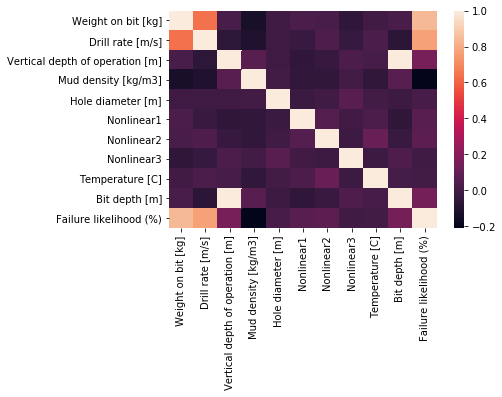

In [51]:
sns.heatmap(df.corr())

In [52]:
sample = Sample(observations=df, target="Failure likelihood (%)")

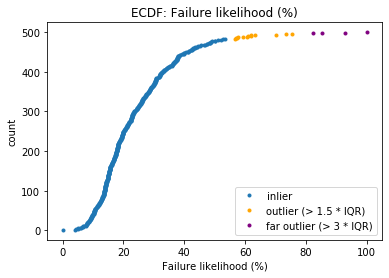

In [53]:
ECDFDrawer().draw(sample.target)

# Feature Selection

In [54]:
boruta = BorutaDF(
    estimator = RandomForestRegressorDF(max_depth=5, random_state=42, n_jobs=3), 
    n_estimators="auto",  
    random_state=42, 
    verbose=0, 
    max_iter=100
)

In [55]:
preprocessing_pipeline = PipelineDF(
    steps = [
        ("impute", SimpleImputerDF()),
        ("feature selection", boruta)
    ]

)

In [58]:
preprocessing_pipeline.fit(X=sample.features, y=sample.target)

PipelineDF(memory=None,
           steps=[('impute',
                   SimpleImputerDF(add_indicator=False, copy=True,
                                   fill_value=None, missing_values=nan,
                                   strategy='mean')),
                  ('feature selection',
                   BorutaDF(estimator=RandomForestRegressor(max_depth=5,
                                                            n_estimators=74,
                                                            n_jobs=3,
                                                            random_state=<mtrand.RandomState object at 0x7f9d8075a870>),
                            n_estimators='auto',
                            random_state=<mtrand.RandomState object at 0x7f9d8075a870>))],
           verbose=False)

In [59]:
print(f"Selected features: {list(preprocessing_pipeline.features_out)}")
sample_selected = sample.keep(preprocessing_pipeline.features_out)

Selected features: ['Weight on bit [kg]', 'Drill rate [m/s]', 'Vertical depth of operation [m]', 'Mud density [kg/m3]', 'Nonlinear1', 'Bit depth [m]']


We can see that the key features that we would expect to effect the safety of the operation would are still being included after the feature selection. A working hypothesis of how these influence the target are: 
- **Weight on bit**: we expect higher weight to increase the likelihood of a failure due to heavier equipment wear
- **Drill rate**: similarly to the above, a higher drill rate leads to more wear & tear of the equipment and thus we expect a positive effect
- **Vertical depth of operation**: the deeper we dig, the more dense we expect the soil to be that we need to dig through, increasing the likelihood of either a collapse or equipment wear
- **Bit depth**: Should contain similar information to the vertical depth of the operation

# Cross validation

We will use a simple Bootstrap for the time series analysis here. Note that if we were given a time series dataset here (i.e. if we had timestamps of the GT readings) we could use a stationary bootstrap here using `StationaryBootstrapCV`)

In [60]:
cv = BootstrapCV(n_splits=10, random_state=42)

# Regressor Pipeline

In [61]:
rf_pipeline = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(n_estimators=500, random_state=42),
)

lgbm_pipeline = RegressorPipelineDF(
    regressor=LGBMRegressorDF(random_state=42),
)

In [63]:
grid = [
    LearnerGrid(
        pipeline=rf_pipeline, 
        learner_parameters={ 
            "min_samples_leaf": [8, 11, 15]
        } 
        ),
    LearnerGrid(
        pipeline=lgbm_pipeline, 
        learner_parameters={ 
            "min_data_in_leaf": [8, 11, 15]
        }
    )
    
]

# Model Ranking

In [66]:
ranker = LearnerRanker( 
    grids=grid, cv=cv, n_jobs=-3
).fit(sample=sample_selected)

LightGBMError: Do not support special JSON characters in feature name.

In [ ]:
ranker.best_model

In [ ]:
print(ranker.summary_report())

# Model inspection

In [ ]:
inspector = RegressorInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit)

In [ ]:
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()

#### Feature redundancy

When plotting out the feature redundancy, we can see that there are some features which contain the same information to the model. In this case, these features are the vertical depth of the operation and the bit depth. 
Intuitively, we can see why these two features are redundant, as the bit depth will be in its most critical stages when it is drilling, i.e. at the vertical depth of operation. 

As we don't want either of the features to confuse the model inference during the simulation step, we should remove the bit depth for this example.

In [ ]:
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy")

In [ ]:
redundant_features = ["Bit depth [m]"]
sample_selected = sample_selected.select_features([feat for feat in sample_selected.features.columns 
                                                   if feat not in redundant_features])

In [ ]:
sample.features

#### Feature synergy
When looking at the synergy matrix, we can easily figure out which of the features have an interaction effect on the target. We see that the weight on the bit and the drill rate in combination appear to have a high synergy. 

In hindsight, this appears obvious - drilling with both high bit weight and a high pace can have a disproportionally large impact on the wear of the equipment.

In [ ]:
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy")

In [ ]:
synergy_matrix

# Simulation

From the synergy matrix, we can see that the Compressor outlet temperature has the highest synergy with most other features. Therefore, we would want to see how the target behaves if we simulate this feature such that each state had a constant outlet compressor temperature. 

First of all, let's see if this is also confirmed by the SHAP feature importances. 

In [ ]:
feat_importance = synergy_matrix.sum(axis=0).reset_index().rename({0: "Total Synergies"}, axis=1)
feat_importance["Total Synergies"] -= 1

In [ ]:
feat_importance.sort_values(by="Total Synergies", ascending=False)

We can see that the strong synergies with all other features of the Compressor outlet air temperature is also visible in the aboslute SHAP values. 

In [ ]:
simulator = UnivariateUpliftSimulator(crossfit = ranker.best_model_crossfit, n_jobs=3)

In [ ]:
We saw from the synergy analysis that the 

In [ ]:
SIM_FEATURE = 'Weight on bit [kg]'
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner = ContinuousRangePartitioner())

fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)

In [ ]:
SIM_FEATURE = 'Mud density [kg/m3]'
simulation = simulator.simulate_feature(name=SIM_FEATURE, partitioner = ContinuousRangePartitioner())

fig, ax = plt.subplots(figsize=(15, 10))

SimulationDrawer().draw(
    data=simulation, title=SIM_FEATURE
)